In [1]:
#Steven Zajac-Descôteaux

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pip install gensim

In [3]:
import pandas as pd
import scipy as sc
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
import sys
### Gensim is outside the anaconda distribution ###
### uncomment to install Gensim ###
#!{sys.executable} -m pip install gensim
import gensim
import gensim.downloader as model_api

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [95]:
COUNTRY_CODE = {'USA': 'us','UK': 'gb','Canada':'ca','Australia': 'au'}
APP_ID = {'Candy Crush': '553834731','Tinder': '547702041','Facebook': '284882215','Twitter': '333903271'}
PAGE_NUMBER = 1

REVIEW_LIST = []

df = pd.DataFrame(columns = ['Country','App','Review','Rating'])

for app, app_id in APP_ID.items():
    for country, c_id in COUNTRY_CODE.items():
        for page in range(1,11): #10 page limit with API 
            r = requests.get(
                f'https://itunes.apple.com/{c_id}/rss/customerreviews/id={app_id}/page={page}/sortby=mostrecent/json'
            )
                
            cont = json.loads(r.content)
            c = cont['feed']['entry']
            PAGE_NUMBER += 1
            for i in range(0,len(c)):
                review = pd.DataFrame({'App':app,'Country': country, 'Rating': [c[i]['im:rating']['label']], 
                                       'Review': [c[i]['content']['label']]})
                REVIEW_LIST.append(review)

df = pd.concat([*REVIEW_LIST,df],ignore_index=True)
df.Rating = pd.to_numeric(df.Rating) #Change rating value to numeric. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   App      8000 non-null   object
 1   Country  8000 non-null   object
 2   Rating   8000 non-null   int64 
 3   Review   8000 non-null   object
dtypes: int64(1), object(3)
memory usage: 250.1+ KB


In [96]:
#1.1
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['Review'])
wordLabels = vectorizer.get_feature_names()

pd.DataFrame(data=X.toarray(),columns=wordLabels).head()

,00,000,01,0932980601,10,100,1000,10000,10000000000,1000s,...,曾经很棒的美国公司现在卖给了中国,有的在點讚和推文的旁邊,监控言论的寡头工具,真實的反而限流,能不能放中文説明,虛假的可以發佈,要杀死言论自由,還有左邊ㄧ系列的功能不是很懂用,非常好玩,𝘩𝘢𝘷𝘦
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
COMPRESSED_SIZE = 200

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['Rating'].values
df['bag_o_words'] = pred
print('OLS R^2: ',r2_score(df['Rating'],pred))

OLS R^2:  0.27047371827656175


In [98]:
import sklearn.feature_extraction.text as text


tf = text.TfidfVectorizer()
X = tf.fit_transform(df['Review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['Rating'].values
df['tf_idf'] = pred
print("OLS R^2: ", r2_score(df['Rating'], pred))

OLS R^2:  0.4397773017898958


In [99]:
#1.2

In [102]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

In [103]:
words = df.Review.str.split()
words = pd.DataFrame(words.tolist())

In [106]:
import re

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df.Review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,623,624,625,626,627,628,629,630,631,632
0,you,can’t,earn,coins,by,winning,levels,you,have,to,...,None,None,None,None,None,None,None,None,None,None
1,game,stopped,working,on,iphone,several,days,ago,None,None,...,None,None,None,None,None,None,None,None,None,None
2,all,network,internet,connections,good,app,is,screwed,up,None,...,None,None,None,None,None,None,None,None,None,None
3,it,won’t,load,on,my,iphone,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,i,like,this,game,it’s,fun,and,relaxing,also,you,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,the,censorship,has,become,so,one,sided,its,bordering,on,...,None,None,None,None,None,None,None,None,None,None
7996,still,have,no,idea,why,i,was,taken,off,periscope,...,None,None,None,None,None,None,None,None,None,None
7997,good,app,but,to,avoid,advert,pollution,go,elsewhere,the,...,None,None,None,None,None,None,None,None,None,None
7998,take,away,the,political,bias,twitter,you,have,a,sinking,...,None,None,None,None,None,None,None,None,None,None


In [107]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
def map_vectors(row):
    try:
        res=row.loc[row.notna()].apply(soft_get)
        if len(res) >=1:
            return np.sum(res)
        else:
            return np.zeros(word_vectors.vector_size)
        # return np.sum(
        #     row.loc[row.notna()].apply(soft_get)
        # )
    except:
        return np.zeros(word_vectors.vector_size)
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,9.802312,3.369429,13.682794,-8.839925,21.449580,-2.956433,-21.957158,1.441315,-10.174165,7.401283,...,-0.493540,1.274259,7.796835,16.215723,-5.491756,0.610078,-6.506909,-0.152367,-5.352584,3.360783
1,2.834230,-1.205298,1.708061,0.654911,-0.739054,0.489657,-8.920521,-0.345140,-1.168422,0.299035,...,-1.959112,-0.276419,-1.201756,1.174718,0.648069,0.547188,-0.558727,-0.837021,-1.938543,-1.071870
2,3.005046,-0.350060,5.530878,2.791646,2.145383,0.235621,-4.590546,-5.576005,2.161267,2.880462,...,2.853337,0.194121,-1.684085,3.832339,-1.730159,0.845190,-0.368492,-0.187688,1.636216,1.010220
3,2.130130,0.060970,2.615990,-0.173047,1.458141,0.740243,-2.382650,-1.497670,1.969672,1.032125,...,1.134917,-0.854080,-2.013227,1.183130,-0.668189,-0.101659,2.076159,-1.189875,0.432221,0.433360
4,1.424204,7.375339,-3.980205,-7.363187,15.509649,2.850387,-16.512418,-4.482613,-9.794640,9.360128,...,-4.373932,4.311252,-2.752963,12.551037,1.113154,6.876689,5.246836,-6.079082,-3.572702,12.062271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,3.415788,-0.593085,0.131434,-0.683880,2.473663,-1.563325,-5.245320,0.263465,-3.905705,-0.926466,...,-0.219860,0.856661,0.012312,4.350139,-1.486569,0.623772,-4.033673,-4.248452,-0.046806,-1.668503
7996,6.859169,0.047282,1.069922,-3.644777,6.548512,-0.001721,-7.900486,-0.233545,-3.643881,0.949069,...,-3.464275,1.814838,1.064769,7.078133,0.002099,-1.954390,-1.572000,-0.258056,0.090782,2.962648
7997,6.576274,-2.106318,1.433384,-0.760129,3.155523,4.249097,-6.836590,-1.711335,1.088546,0.056594,...,-0.605124,0.240534,-1.192840,4.737397,-0.059735,3.182178,-4.500384,0.564768,5.381928,-2.742391
7998,3.921168,0.478038,2.338093,-2.246403,2.296425,1.894723,-4.755939,1.014526,-0.204938,-1.370434,...,-0.746460,-0.747753,-0.131469,2.866285,0.709924,-2.335305,-0.353492,0.634378,2.384493,-3.197133


In [108]:
from sklearn.preprocessing import Normalizer,StandardScaler
X = Normalizer().fit_transform(emb) #Normalizer gives better score
sgdr = SGDRegressor()
sgdr.fit(X, df.Rating)
df['gensim'] = sgdr.predict(X)
sgdr.score(X, df.Rating)

0.27937567640889116

In [109]:
#1.3

In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

X = PCA_df
y = df.Rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)

scaled_X_test = scaler.transform(X_test)

model = LinearRegression()

model.fit(X_train,y_train)

preds = model.predict(X_test)

In [173]:
mean_absolute_error(y_test,preds)

0.9153303024309213

In [175]:
r2_score(y_test,preds)

0.44354381022597256

In [110]:
#1.4

#Using PCA

tf = text.TfidfVectorizer()
X = tf.fit_transform(df['Review'])
Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
PCA_df = pd.DataFrame(Xd)

X = PCA_df
y = df.Rating
model = RandomForestClassifier().fit(X,y)
preds = model.predict(X)
df['RF_preds_PCA'] = preds

print('Accuracy: {0}, R^2: {1}'.format(accuracy_score(df.Rating,preds),r2_score(df['Rating'], preds)))

Accuracy: 0.992375, R^2: 0.9631898892257769


In [111]:
#Using gensim

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,r2_score


X = emb
y = df.Rating
model = RandomForestClassifier().fit(X,y)
preds = model.predict(X)
df['RF_preds_emb'] = preds

print('Accuracy: {0}, R^2: {1}'.format(accuracy_score(df.Rating,preds),r2_score(df['Rating'], preds)))

Accuracy: 0.992875, R^2: 0.9651163023780347


In [165]:
df

,App,Country,Rating,Review,bag_o_words,tf_idf,gensim,RF_preds_PCA,RF_preds_emb
0,Candy Crush,USA,2,You can’t earn coins by winning levels. You h...,1.973085,1.563404,1.933913,2,2
1,Candy Crush,USA,1,Game stopped working on iPhone several days ago,2.124316,1.542667,1.877235,1,1
2,Candy Crush,USA,1,All network/internet connections good. App is ...,2.709026,3.004304,1.989781,1,1
3,Candy Crush,USA,1,It won’t load on my iPhone!,2.031029,1.647251,2.115538,1,1
4,Candy Crush,USA,5,I like this game! It’s fun and relaxing. Also ...,5.052145,5.656469,3.096269,5,5
...,...,...,...,...,...,...,...,...,...
7995,Twitter,Australia,1,The censorship has become so one sided its bor...,1.644842,1.903558,1.549871,1,1
7996,Twitter,Australia,3,Still have no idea why I was taken off perisco...,2.604779,2.097063,2.156158,3,3
7997,Twitter,Australia,2,Good app but to avoid advert pollution. Go els...,2.786349,2.338674,1.479636,2,2
7998,Twitter,Australia,1,"Take away the Political bias Twitter, you have...",2.156926,1.766269,1.259455,1,1


Classification models have the best accuracy when it comes to predicting the star ratings. As we can see the RandomForests Classifier using Gensim returned the best accuracy and r2 scores. This can be seen with the accuracy score of .993 and r2 of .965 for Gensim and RF classifier while our LinearRegression model has a R2 score of: 0.444. which is less than half of the better model. 

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [4]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

In [25]:
#faces.data

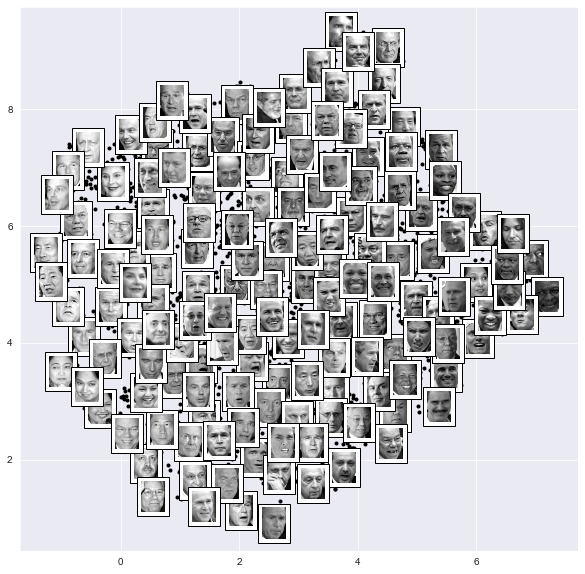

In [125]:
from sklearn.manifold import Isomap
#import umap
import umap.umap_ as umap
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 10),)
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(faces.data, model, images=faces.images[:,::2,::2], #All images and change the shape
                ax=ax, thumb_frac=0.05)

In [ ]:
####MISC STUFF####

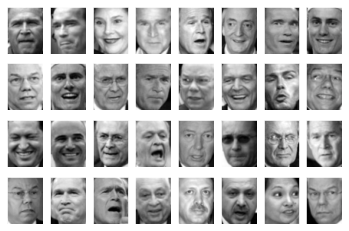

In [104]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

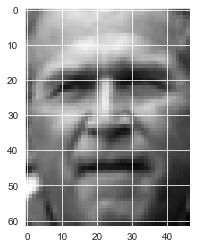

In [105]:
#for i in range(0,2370):
plt.imshow(faces.data[0].reshape(62,47),cmap='binary_r')

In [101]:
faces.data.shape

(2370, 2914)

In [92]:
faces.images[:,::2,::2].shape

(2370, 31, 24)

In [49]:
range(100)[5:18:2] #Start at 5 end at 18-1 at every 2

range(5, 18, 2)

In [ ]:
[]